# 01 — Spacecraft Dynamics Setup with Tudat

This notebook established the dynamical environment and numerical propagation of a Juno-like spacecraft.
The resulting state history will be used in the next notebooks to simulate radio science observables and perform orbit determination.

Mission scenario: Juno-like spacecraft orbiting Jupiter.


#### - Imports

In [16]:
import numpy as np
from matplotlib import pyplot as plt

from tudatpy.interface import spice
from tudatpy import dynamics
from tudatpy.dynamics import environment_setup, propagation_setup
from tudatpy.astro import element_conversion
from tudatpy import constants
from tudatpy.util import result2array
from tudatpy.astro.time_representation import DateTime

In [6]:
spice.load_standard_kernels()

#### - Simulation epoch

Defining an arbitrary (but realistic) epoch for a Juno-like orbit around Jupiter.
All epochs are expressed in seconds since J2000.

In [8]:
simulation_start_epoch = 0.0  # seconds since J2000
simulation_end_epoch = simulation_start_epoch + 2.0 * 24.0 * 3600.0 # 2 days

#### - Definition of celestial bodies and spacecraft used in the dynamical model.


In [17]:
bodies_to_create = ["Jupiter", "Sun"]

global_frame_origin = "Jupiter"
global_frame_orientation = "J2000"

body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation
)

bodies = environment_setup.create_system_of_bodies(body_settings)

#### - Creating a spacecraft


In [18]:
spacecraft_name = "Juno"

bodies.create_empty_body(spacecraft_name)

#### - Dynamical model

The spacecraft motion is modeled including:
- Central gravity of Jupiter
- Jupiter J2 perturbation
- Third-body gravitational perturbation from the Sun

In [20]:
acceleration_settings = {
    spacecraft_name: {
        "Jupiter": [
            propagation_setup.acceleration.point_mass_gravity(),
            propagation_setup.acceleration.spherical_harmonic_gravity(2, 0)
        ],
        "Sun": [
            propagation_setup.acceleration.point_mass_gravity()
        ]
    }
}

In [21]:
acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate=[spacecraft_name],
    central_bodies=["Jupiter"]
)

#### - Initial state

The initial state is defined in Keplerian elements and converted to Cartesian coordinates.


In [22]:
jupiter_gravitational_parameter = bodies.get_body("Jupiter").gravitational_parameter

initial_keplerian_elements = np.array([
    20.0e7,                 # semi-major axis [m]
    0.6,                    # eccentricity
    np.deg2rad(90.0),       # inclination
    np.deg2rad(0.0),        # argument of periapsis
    np.deg2rad(0.0),        # longitude of ascending node
    np.deg2rad(0.0)         # true anomaly
])

In [23]:
initial_cartesian_state = element_conversion.keplerian_to_cartesian(
    initial_keplerian_elements,
    jupiter_gravitational_parameter
)

#### - Propagation settings

In [28]:
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch,
    60.0
)

propagator_settings = propagation_setup.propagator.translational(
    central_bodies=["Jupiter"],
    acceleration_models=acceleration_models,
    bodies_to_integrate=[spacecraft_name],   # <-- NOME CORRETO
    initial_states=initial_cartesian_state,
    initial_time=simulation_start_epoch,
    integrator_settings=integrator_settings,
    termination_settings=propagation_setup.propagator.time_termination(
        simulation_end_epoch
    )
)

In [30]:
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies,
    propagator_settings
)

state_history = dynamics_simulator.state_history

#### - Show results

In [31]:
state_array = result2array(state_history)
time = state_array[:, 0]
states = state_array[:, 1:]

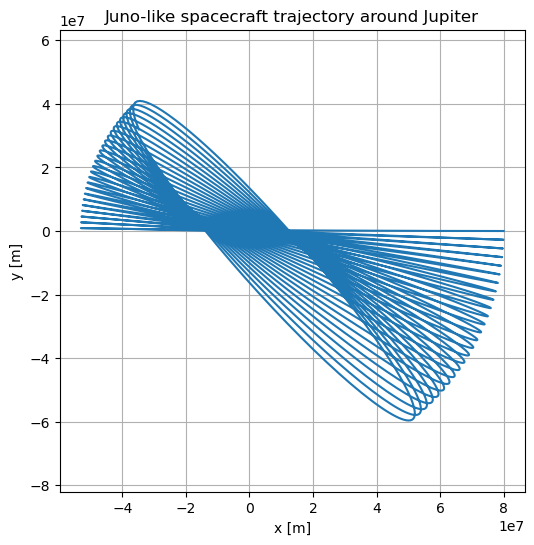

In [32]:
plt.figure(figsize=(6, 6))
plt.plot(states[:, 0], states[:, 1])
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Juno-like spacecraft trajectory around Jupiter")
plt.axis("equal")
plt.grid()
plt.show()